<a href="https://colab.research.google.com/github/PrathamBhushan/AIHT_unit4/blob/main/AIHT_unit4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Phase 1: Setup and Data Loading
!pip install pyspark

from pyspark.sql import SparkSession
from google.colab import files
import pandas as pd

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
file_path = f"/content/{file_name}"

spark = SparkSession.builder.appName("LegalTextClassification").getOrCreate()


df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

df.show(5)

Saving legal_text_classification.csv to legal_text_classification.csv
+-------+------------+--------------------+--------------------+
|case_id|case_outcome|          case_title|           case_text|
+-------+------------+--------------------+--------------------+
|  Case1|       cited|Alpine Hardwood (...|Ordinarily that d...|
|  Case2|       cited|Black v Lipovac [...|"The general prin...|
|  Case3|       cited|Colgate Palmolive...|Ordinarily that d...|
|  Case4|       cited|Dais Studio Pty L...|"The general prin...|
|  Case5|       cited|Dr Martens Austra...|The preceding gen...|
+-------+------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# Phase 2: Data Preprocessing and Partitioning
from pyspark.sql.functions import col, lower

# Drop null values
df = df.dropna()

# Convert text column to lowercase
df = df.withColumn("case_text", lower(col("case_text")))

# Partition the data
df = df.repartition(4, "case_outcome")


In [ ]:
# Phase 3: Distributed Database Implementation
# Register DataFrame as a temporary SQL table
df.createOrReplaceTempView("legal_data")

# Querying the stored data
query_result = spark.sql("SELECT case_outcome, COUNT(*) AS count FROM legal_data GROUP BY case_outcome")
query_result.show()

+-------------+-----+
| case_outcome|count|
+-------------+-----+
|      applied| 2438|
|     followed| 2252|
|  referred to| 4363|
|     approved|  108|
|        cited|12110|
|     affirmed|  106|
|    discussed| 1018|
|      related|  112|
|   considered| 1699|
|distinguished|  603|
+-------------+-----+



In [ ]:
# Phase 4: Query and Analysis
# Find most frequent words in case_text column
from pyspark.sql.functions import split, explode

words_df = df.withColumn("word", explode(split(col("case_text"), " ")))
word_counts = words_df.groupBy("word").count().orderBy(col("count").desc())
word_counts.show(10)

+----+------+
|word| count|
+----+------+
| the|447219|
|  of|241400|
|  to|175718|
|  in|142212|
|that|109652|
| and|106389|
|   a|103552|
|  is| 71944|
|  at| 63233|
|   v| 62394|
+----+------+
only showing top 10 rows



In [ ]:
# Phase 5: AI Model Training and Evaluation
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when, count

# Convert text to tokens
tokenizer = Tokenizer(inputCol="case_text", outputCol="words")

# Convert words to TF-IDF features
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Convert case outcome labels to indexed values
labelIndexer = StringIndexer(inputCol="case_outcome", outputCol="label")

# Train a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Create pipeline
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, labelIndexer, lr])

# Split data into train and test
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Train model
model = pipeline.fit(train_df)

# Evaluate model
predictions = model.transform(test_df)
predictions.select("case_text", "case_outcome", "prediction").show(5)

# Calculate accuracy
correct_preds = predictions.withColumn(
    "correct", when(col("label") == col("prediction"), 1).otherwise(0)
)

accuracy = correct_preds.agg(
    (count(when(col("correct") == 1, True)) / count("*")).alias("accuracy")
).collect()[0]["accuracy"]

print(f"Model Accuracy: {accuracy:.2%}")


+--------------------+------------+----------+
|           case_text|case_outcome|prediction|
+--------------------+------------+----------+
|"applicant relies...|     applied|       4.0|
|view of such auth...|    followed|       3.0|
|"purposes identif...| referred to|       2.0|
|"word ""false"" i...|     applied|       2.0|
|agree with the ap...|    approved|       5.0|
+--------------------+------------+----------+
only showing top 5 rows

Model Accuracy: 53.89%


In [ ]:
!pip install seaborn matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


<ipython-input-25-824c4ac332fa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='case_outcome', y='count', data=query_result_pd, palette='viridis')


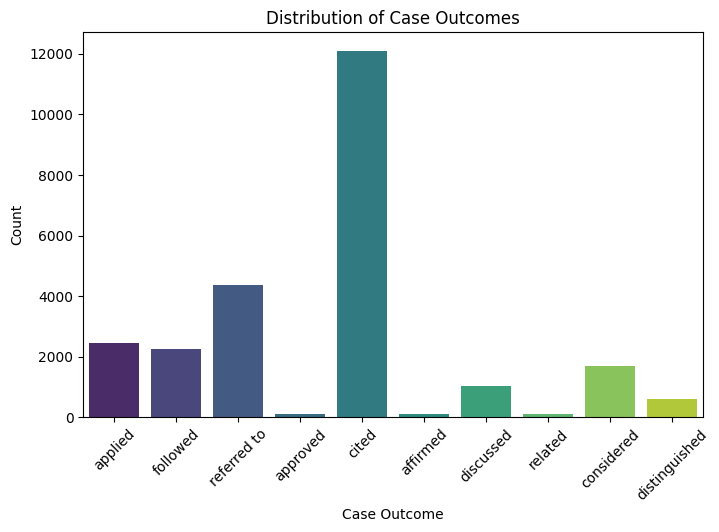

In [ ]:
query_result_pd = query_result.toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(x='case_outcome', y='count', data=query_result_pd, palette='viridis')
plt.title('Distribution of Case Outcomes')
plt.xlabel('Case Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


<ipython-input-26-7b2a93238079>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='word', x='count', data=word_counts_pd, palette='magma')


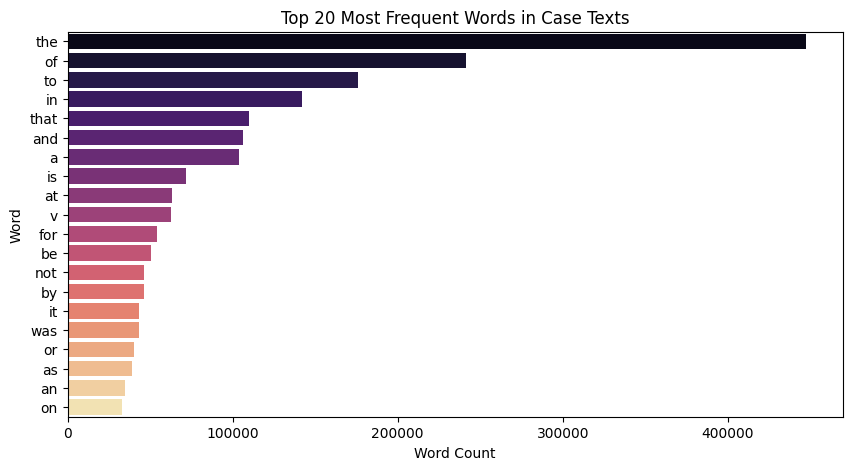

In [ ]:
word_counts_pd = word_counts.limit(20).toPandas()
plt.figure(figsize=(10, 5))
sns.barplot(y='word', x='count', data=word_counts_pd, palette='magma')
plt.title('Top 20 Most Frequent Words in Case Texts')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.show()


<ipython-input-27-c82ecf582dbb>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='case_outcome', y='avg(text_length)', data=text_length_pd, palette='coolwarm')


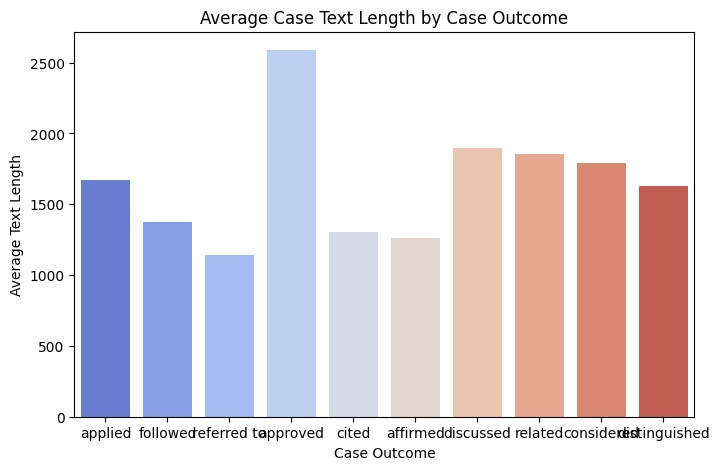

In [ ]:
from pyspark.sql.functions import length

df = df.withColumn("text_length", length(col("case_text")))
text_length_pd = df.groupBy("case_outcome").avg("text_length").toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x='case_outcome', y='avg(text_length)', data=text_length_pd, palette='coolwarm')
plt.title('Average Case Text Length by Case Outcome')
plt.xlabel('Case Outcome')
plt.ylabel('Average Text Length')
plt.show()


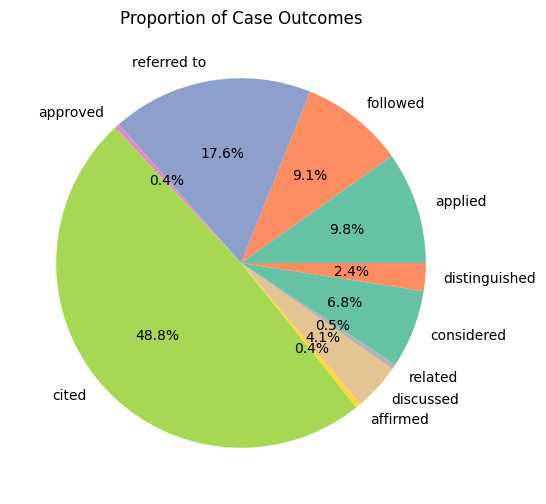

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(query_result_pd['count'], labels=query_result_pd['case_outcome'], autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Proportion of Case Outcomes')
plt.show()


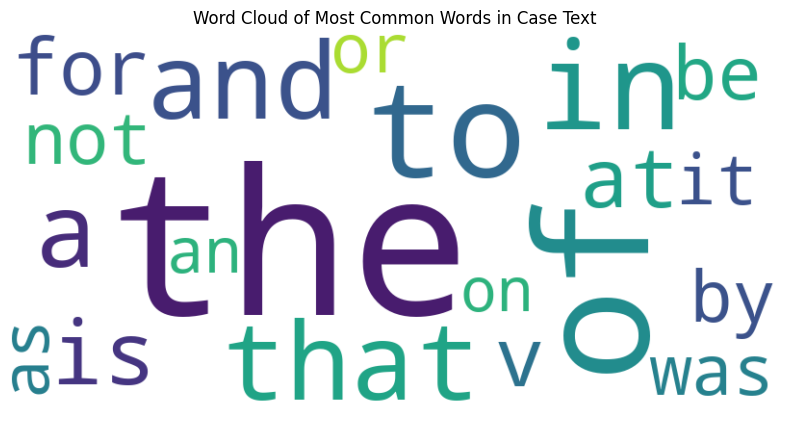

In [ ]:
from wordcloud import WordCloud

word_freq_dict = dict(zip(word_counts_pd['word'], word_counts_pd['count']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordclodsud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words in Case Text")
plt.show()


<ipython-input-30-8380fb66b84e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='case_outcome', y='text_length', data=text_length_pd, palette='pastel')


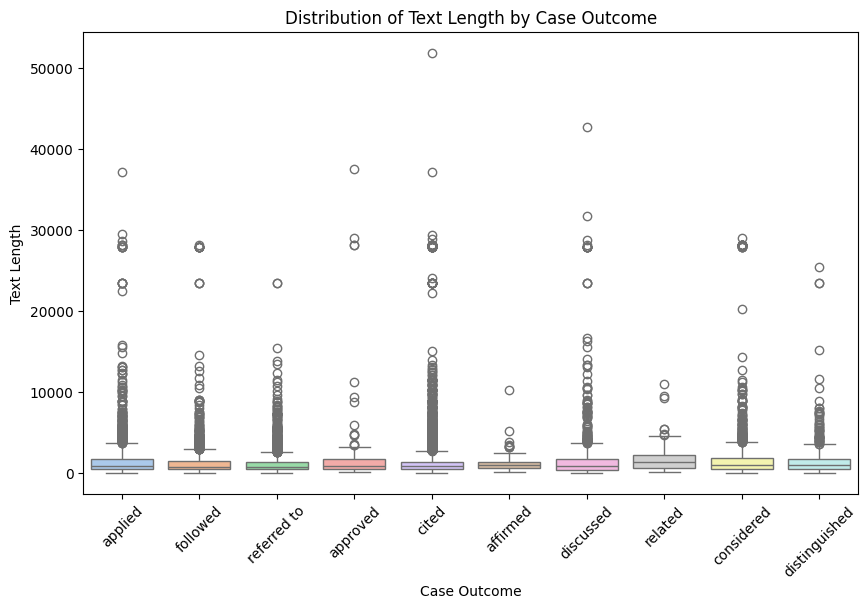

In [ ]:
text_length_pd = df.select("case_outcome", "text_length").toPandas()
plt.figure(figsize=(10, 6))
sns.boxplot(x='case_outcome', y='text_length', data=text_length_pd, palette='pastel')
plt.title('Distribution of Text Length by Case Outcome')
plt.xlabel('Case Outcome')
plt.ylabel('Text Length')
plt.xticks(rotation=45)
plt.show()


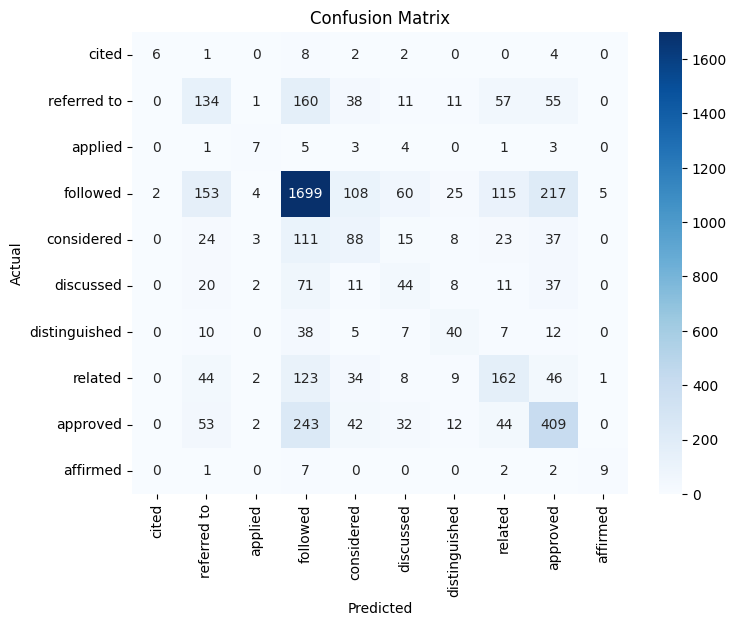

In [ ]:
from pyspark.ml.feature import IndexToString, StringIndexer

# Convert actual case_outcome labels to numeric
labelIndexer = StringIndexer(inputCol="case_outcome", outputCol="label")
labelIndexerModel = labelIndexer.fit(df)  # Fit to get labels

# Convert numeric predictions back to original labels
labelConverter = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=labelIndexerModel.labels)
predictions = labelConverter.transform(predictions)

# Convert DataFrame to Pandas for confusion matrix
predictions_pd = predictions.select("case_outcome", "predicted_label").toPandas()

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(predictions_pd["case_outcome"], predictions_pd["predicted_label"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labelIndexerModel.labels, yticklabels=labelIndexerModel.labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


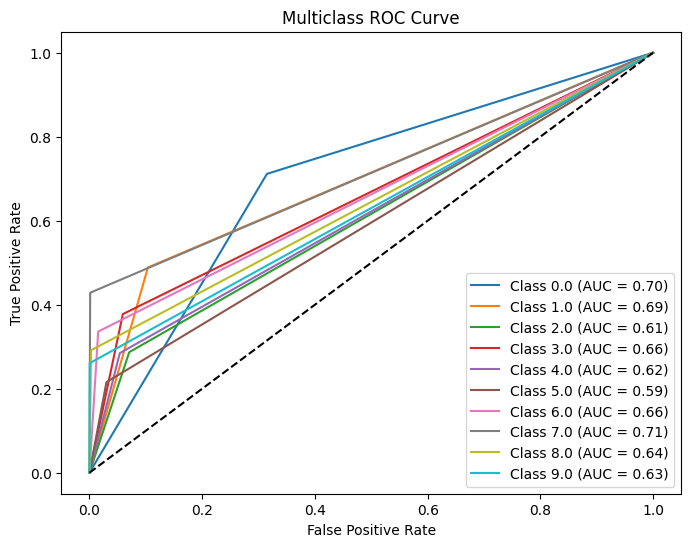

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Convert labels and predictions to Pandas DataFrame
predictions_pd = predictions.select("label", "prediction").toPandas()

# Convert to NumPy arrays
y_true = predictions_pd["label"].values
y_pred = predictions_pd["prediction"].values

# One-hot encode the labels for multi-class ROC
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

# Compute ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(y_true_bin.shape[1]):  # Iterate over each class
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], (y_pred == i).astype(int))
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, PCA
from pyspark.ml import Pipeline

# Step 1: Tokenize text into words
tokenizer = Tokenizer(inputCol="case_text", outputCol="words")

# Step 2: Convert words into term frequencies
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)

# Step 3: Compute TF-IDF features
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Step 4: Apply PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")

# Create a pipeline for transformation
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, pca])

# Fit the pipeline and transform the data
model = pipeline.fit(df)
df_pca = model.transform(df)

# Show transformed PCA features
df_pca.select("pca_features").show(5, truncate=False)


+----------------------------------------+
|pca_features                            |
+----------------------------------------+
|[-2.796289744256766,1.35972929306325]   |
|[-9.9020495008819,3.554835329066216]    |
|[-17.479368410405606,2.8475077863345066]|
|[-6.877430925052059,0.2901369996223958] |
|[-4.424630601663891,1.112066255668654]  |
+----------------------------------------+
only showing top 5 rows



<ipython-input-36-1b6486266a7d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="case_outcome", y="text_length", data=text_length_pd, palette="muted")


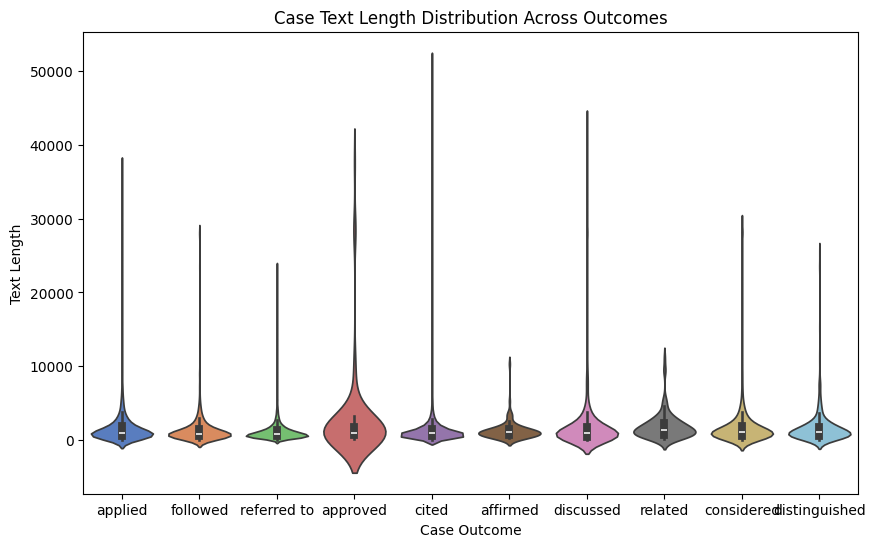

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="case_outcome", y="text_length", data=text_length_pd, palette="muted")
plt.title("Case Text Length Distribution Across Outcomes")
plt.xlabel("Case Outcome")
plt.ylabel("Text Length")
plt.show()
